<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/FT_Transformer(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== F1-Transformer Crop Production Classification ===

Using device: cpu

Loading datasets...
Train set shape: (3584, 84)
Validation set shape: (768, 84)
Test set shape: (768, 84)
Feature dimensions: 83
Label distribution in training set:
  Very Low: 717 (20.0%)
  Low: 717 (20.0%)
  Medium: 716 (20.0%)
  High: 717 (20.0%)
  Very High: 717 (20.0%)
Model parameters: 614,533
Trainable parameters: 614,533

Training model for 50 epochs...
Epoch [10/50]
  Train Loss: 0.5840, Train Acc: 78.66%
  Val Loss: 0.5570, Val Acc: 78.78%
  Val Macro F1: 0.7868
Epoch [20/50]
  Train Loss: 0.4331, Train Acc: 83.71%
  Val Loss: 0.4757, Val Acc: 82.42%
  Val Macro F1: 0.8228
Epoch [30/50]
  Train Loss: 0.2739, Train Acc: 89.56%
  Val Loss: 0.4028, Val Acc: 86.33%
  Val Macro F1: 0.8635
Epoch [40/50]
  Train Loss: 0.2115, Train Acc: 91.52%
  Val Loss: 0.4712, Val Acc: 85.81%
  Val Macro F1: 0.8577
Epoch [50/50]
  Train Loss: 0.1333, Train Acc: 94.61%
  Val Loss: 0.5491, Val Acc: 85.94%
  Val Macro F1: 0.85

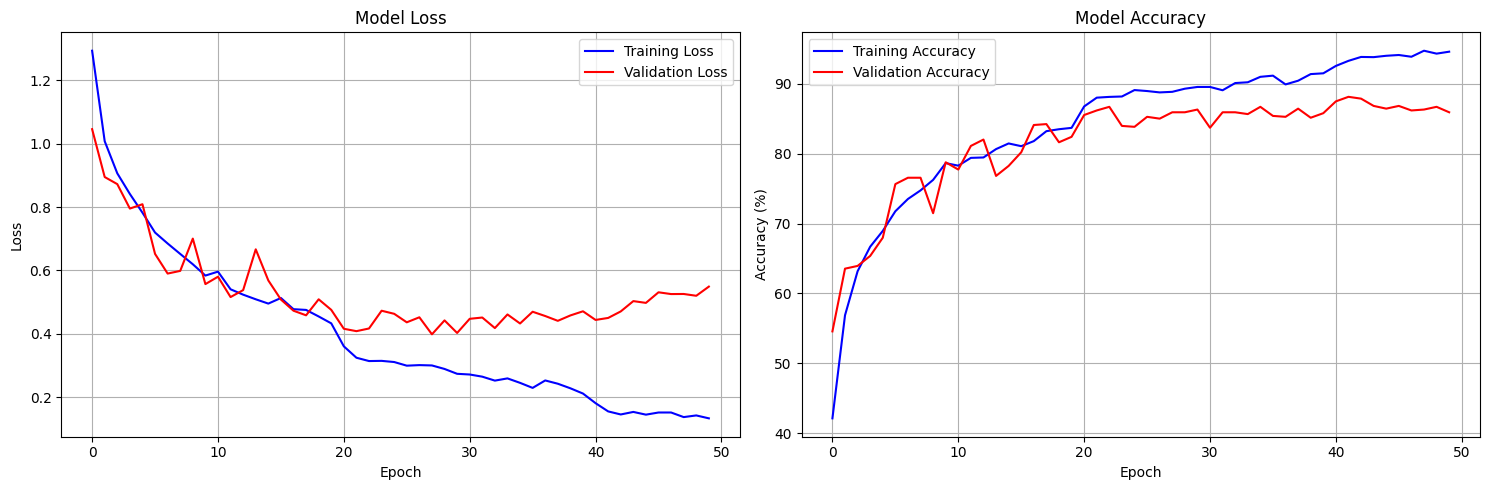


=== Validation Set Evaluation ===
Validation Metrics:
  Accuracy: 0.8594
  Precision (Macro): 0.8591
  Recall (Macro): 0.8591
  F1 Score (Macro): 0.8576
  F1 Score (Weighted): 0.8581

=== Test Set Evaluation ===
Test Metrics:
  Accuracy: 0.8490
  Precision (Macro): 0.8500
  Recall (Macro): 0.8453
  F1 Score (Macro): 0.8467
  F1 Score (Weighted): 0.8485

Plotting confusion matrices...


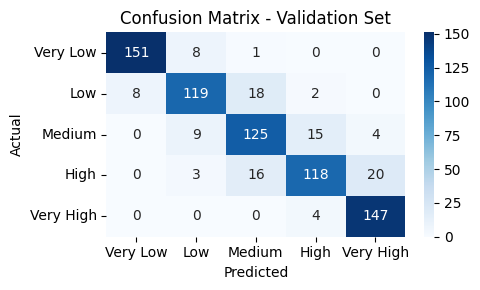

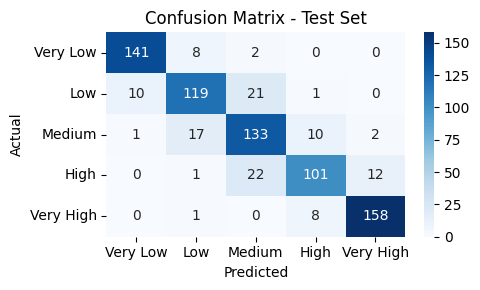


=== Detailed Classification Report - Validation Set ===
              precision    recall  f1-score   support

    Very Low       0.95      0.94      0.95       160
         Low       0.86      0.81      0.83       147
      Medium       0.78      0.82      0.80       153
        High       0.85      0.75      0.80       157
   Very High       0.86      0.97      0.91       151

    accuracy                           0.86       768
   macro avg       0.86      0.86      0.86       768
weighted avg       0.86      0.86      0.86       768


=== Detailed Classification Report - Test Set ===
              precision    recall  f1-score   support

    Very Low       0.93      0.93      0.93       151
         Low       0.82      0.79      0.80       151
      Medium       0.75      0.82      0.78       163
        High       0.84      0.74      0.79       136
   Very High       0.92      0.95      0.93       167

    accuracy                           0.85       768
   macro avg       0.85

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class CropDataset(Dataset):
    """Custom Dataset for crop production data"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class F1TransformerModel(nn.Module):
    """F1-Transformer model for crop production classification"""
    def __init__(self, input_dim, num_classes=5, d_model=128, nhead=8, num_layers=3, dropout=0.1):
        super(F1TransformerModel, self).__init__()

        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding (simple learned embedding)
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes)
        )

    def forward(self, x):
        # Project input to d_model dimensions
        x = self.input_projection(x)  # [batch_size, d_model]

        # Add batch and sequence dimensions for transformer
        x = x.unsqueeze(1)  # [batch_size, 1, d_model]

        # Add positional encoding
        x = x + self.pos_embedding

        # Pass through transformer encoder
        x = self.transformer_encoder(x)  # [batch_size, 1, d_model]

        # Remove sequence dimension and classify
        x = x.squeeze(1)  # [batch_size, d_model]
        output = self.classifier(x)

        return output

def load_and_preprocess_data():
    """Load and preprocess the CSV files"""
    print("Loading datasets...")

    # Load datasets
    train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

    print(f"Train set shape: {train_df.shape}")
    print(f"Validation set shape: {val_df.shape}")
    print(f"Test set shape: {test_df.shape}")

    # Handle missing values
    for df in [train_df, val_df, test_df]:
        df.fillna(df.mean(numeric_only=True), inplace=True)

    # Create quantile-based labels for production
    production_col = 'Production (M.Ton)'

    # Calculate quantiles from training data only
    quantiles = train_df[production_col].quantile([0.2, 0.4, 0.6, 0.8]).values

    def create_labels(production_values, quantiles):
        """Create 5-level labels based on quantiles"""
        labels = []
        for val in production_values:
            if val <= quantiles[0]:
                labels.append(0)  # Very Low
            elif val <= quantiles[1]:
                labels.append(1)  # Low
            elif val <= quantiles[2]:
                labels.append(2)  # Medium
            elif val <= quantiles[3]:
                labels.append(3)  # High
            else:
                labels.append(4)  # Very High
        return np.array(labels)

    # Create labels
    train_labels = create_labels(train_df[production_col].values, quantiles)
    val_labels = create_labels(val_df[production_col].values, quantiles)
    test_labels = create_labels(test_df[production_col].values, quantiles)

    # Remove target column from features
    feature_cols = [col for col in train_df.columns if col != production_col]

    X_train = train_df[feature_cols].values
    X_val = val_df[feature_cols].values
    X_test = test_df[feature_cols].values

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Feature dimensions: {X_train_scaled.shape[1]}")
    print(f"Label distribution in training set:")
    unique, counts = np.unique(train_labels, return_counts=True)
    label_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    for i, (label, count) in enumerate(zip(unique, counts)):
        print(f"  {label_names[label]}: {count} ({count/len(train_labels)*100:.1f}%)")

    return (X_train_scaled, train_labels, X_val_scaled, val_labels,
            X_test_scaled, test_labels, scaler, quantiles)

def train_model(model, train_loader, val_loader, num_epochs=50, device='cpu'):
    """Train the F1-Transformer model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_f1 = 0
    best_model_state = None

    print(f"Training model for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_true = []

        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()

                val_predictions.extend(predicted.cpu().numpy())
                val_true.extend(batch_labels.cpu().numpy())

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        val_f1_macro = f1_score(val_true, val_predictions, average='macro')

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Save best model based on macro F1 score
        if val_f1_macro > best_val_f1:
            best_val_f1 = val_f1_macro
            best_model_state = model.state_dict().copy()

        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
            print(f'  Val Macro F1: {val_f1_macro:.4f}')

    # Load best model
    model.load_state_dict(best_model_state)
    print(f'Best validation macro F1 score: {best_val_f1:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, data_loader, device='cpu'):
    """Evaluate model and return predictions and true labels"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_features, batch_labels in data_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

def calculate_metrics(y_true, y_pred):
    """Calculate all classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1 Score (Macro)': f1_macro,
        'F1 Score (Weighted)': f1_weighted
    }

def plot_confusion_matrix(y_true, y_pred, title, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    """Main training and evaluation pipeline"""
    print("=== F1-Transformer Crop Production Classification ===\n")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")

    # Load and preprocess data
    (X_train, y_train, X_val, y_val, X_test, y_test,
     scaler, quantiles) = load_and_preprocess_data()

    # Create datasets and data loaders
    train_dataset = CropDataset(X_train, y_train)
    val_dataset = CropDataset(X_val, y_val)
    test_dataset = CropDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    input_dim = X_train.shape[1]
    model = F1TransformerModel(input_dim=input_dim, num_classes=5).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")

    # Train model
    num_epochs = 50
    model, train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, num_epochs, device
    )

    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(train_losses, val_losses, train_accs, val_accs)

    # Evaluate on validation set
    print("\n=== Validation Set Evaluation ===")
    val_pred, val_true = evaluate_model(model, val_loader, device)
    val_metrics = calculate_metrics(val_true, val_pred)

    print("Validation Metrics:")
    for metric, value in val_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Evaluate on test set
    print("\n=== Test Set Evaluation ===")
    test_pred, test_true = evaluate_model(model, test_loader, device)
    test_metrics = calculate_metrics(test_true, test_pred)

    print("Test Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Class names
    class_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

    # Plot confusion matrices
    print("\nPlotting confusion matrices...")
    plot_confusion_matrix(val_true, val_pred, "Validation Set", class_names)
    plot_confusion_matrix(test_true, test_pred, "Test Set", class_names)

    # Detailed classification reports
    print("\n=== Detailed Classification Report - Validation Set ===")
    print(classification_report(val_true, val_pred, target_names=class_names))

    print("\n=== Detailed Classification Report - Test Set ===")
    print(classification_report(test_true, test_pred, target_names=class_names))

    # Summary table
    print("\n=== Final Results Summary ===")
    results_df = pd.DataFrame({
        'Dataset': ['Validation', 'Test'],
        'Accuracy': [val_metrics['Accuracy'], test_metrics['Accuracy']],
        'Precision (Macro)': [val_metrics['Precision (Macro)'], test_metrics['Precision (Macro)']],
        'Recall (Macro)': [val_metrics['Recall (Macro)'], test_metrics['Recall (Macro)']],
        'F1 Score (Macro)': [val_metrics['F1 Score (Macro)'], test_metrics['F1 Score (Macro)']],
        'F1 Score (Weighted)': [val_metrics['F1 Score (Weighted)'], test_metrics['F1 Score (Weighted)']]
    })

    print(results_df.round(4).to_string(index=False))

    return model, scaler, quantiles

if __name__ == "__main__":
    # Run the complete pipeline
    trained_model, fitted_scaler, production_quantiles = main()

    print("\n=== Training Complete ===")
    print("Model trained successfully!")
    print("All metrics calculated and plots generated.")